In [1]:
#spark

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when, min, max, col
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re

**Load Datasets**

In [2]:
workspace_default_storage_account = "group08astoragec0a5c9b39"
workspace_default_container = "azureml-blobstore-8f67895d-e507-48c5-8b8e-f003f0227b44"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)
df = spark.read.parquet((f"{workspace_wasbs_base_url}<PATH-TO-READ/WRITE>"))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 15, 7, Finished, Available)

## Find out the most popular leagues and clubs on Reddit

In [6]:
# define target subreddits 
league_subreddits = ["PremierLeague", "Bundesliga", "seriea", "LaLiga", "MLS", "worldcup"]
club_subreddits = ["chelseafc", "reddevils", "Gunners", "Barca", "realmadrid", "ACMilan", "Juve", 
    "ASRoma", "fcbayern", "borussiadortmund", "schalke04", "atletico", "psg", "ajaxAmsterdam", 
    "celticfc"]

# filter the dataset with subreddits I would like to explore
df_league = df.filter(df["subreddit"].isin(league_subreddits)).\
    select("subreddit", "controversiality", "score").cache()
df_club = df.filter(df["subreddit"].isin(club_subreddits)).\
    select("subreddit", "controversiality", "score").cache()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 11, 11, Finished, Available)

In [7]:
# add a column to group the clubs by league
classification_rules = {
    "Premier League": ["chelseafc", "reddevils", "Gunners"],
    "La Liga": ["Barca", "realmadrid", "atletico"],
    "Serie A": ["ACMilan", "Juve", "ASRoma"],
    "Bundesliga": ["fcbayern", "borussiadortmund", "schalke04"],
    "Other": ["psg", "ajaxAmsterdam", "celticfc"]
}

df_club = df_club.withColumn(
    "league",
    when(df_club["subreddit"].isin(classification_rules["Premier League"]), "Premier League")
    .when(df_club["subreddit"].isin(classification_rules["La Liga"]), "La Liga")
    .when(df_club["subreddit"].isin(classification_rules["Serie A"]), "Serie A")
    .when(df_club["subreddit"].isin(classification_rules["Bundesliga"]), "Bundesliga")
    .otherwise("Other"))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 11, 12, Finished, Available)

In [8]:
# count the number of comments for each league
count_league = df_league.groupBy("subreddit").agg(f.count("*").alias("count")).toPandas().\
    sort_values(by='count', ascending=False)

# count the number of comments for each club
count_club = df_club.groupBy("subreddit", "league").agg(f.count("*").alias("count")).toPandas().\
    sort_values(by='count', ascending=False)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 11, 13, Finished, Available)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 4, 41, Finished, Available)

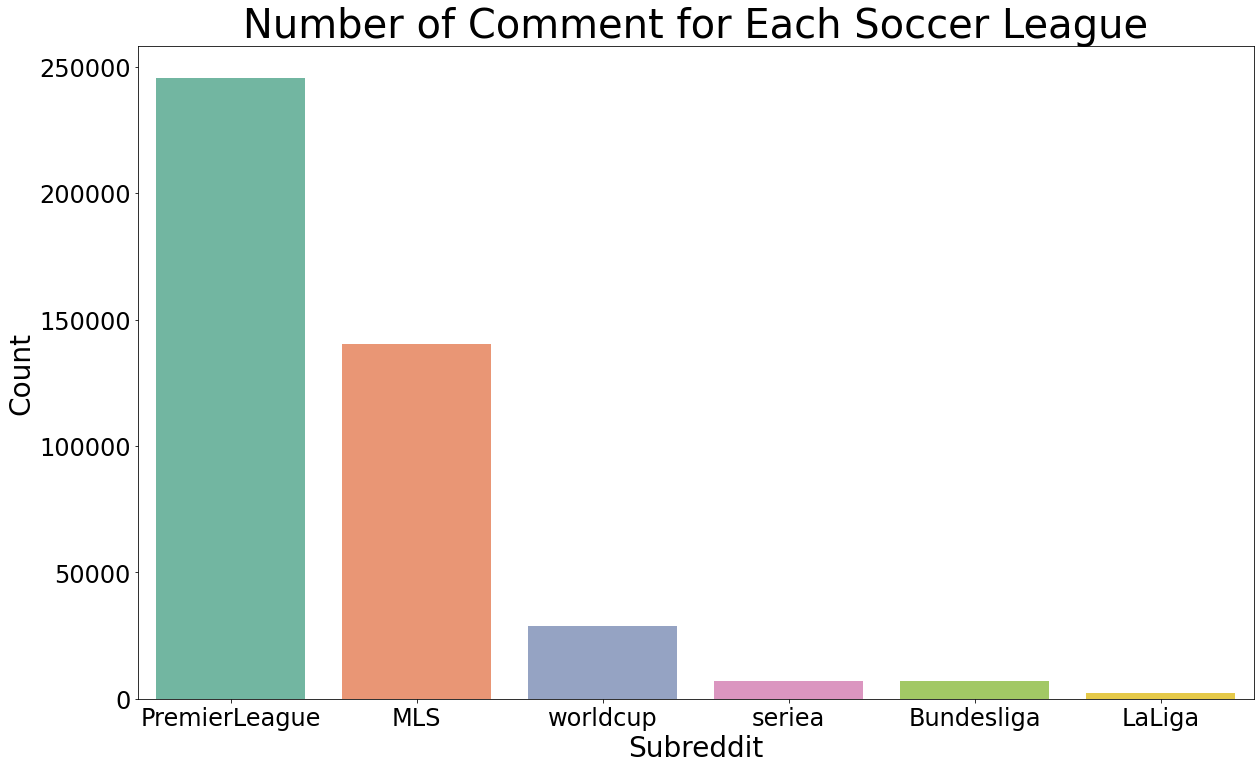

In [36]:
# plot bar plot for the number of comments for leagues
plt.figure(figsize=(20, 12))
sns.barplot(x='subreddit', y='count', data=count_league, palette='Set2')
plt.title('Number of Comment for Each Soccer League', fontsize=40)
plt.xlabel('Subreddit', fontsize=28)
plt.ylabel('Count', fontsize=28)
plt.tick_params(axis='both', labelsize=24)
plt.show()

The provided data reveals varying levels of activity across major soccer league subreddits. "PremierLeague" and "MLS" stand out as highly active communities, while "worldcup" also enjoys a substantial presence. In contrast, "seriea," "Bundesliga," and "LaLiga" have comparatively lower levels of engagement within their respective subreddits.

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 4, 40, Finished, Available)

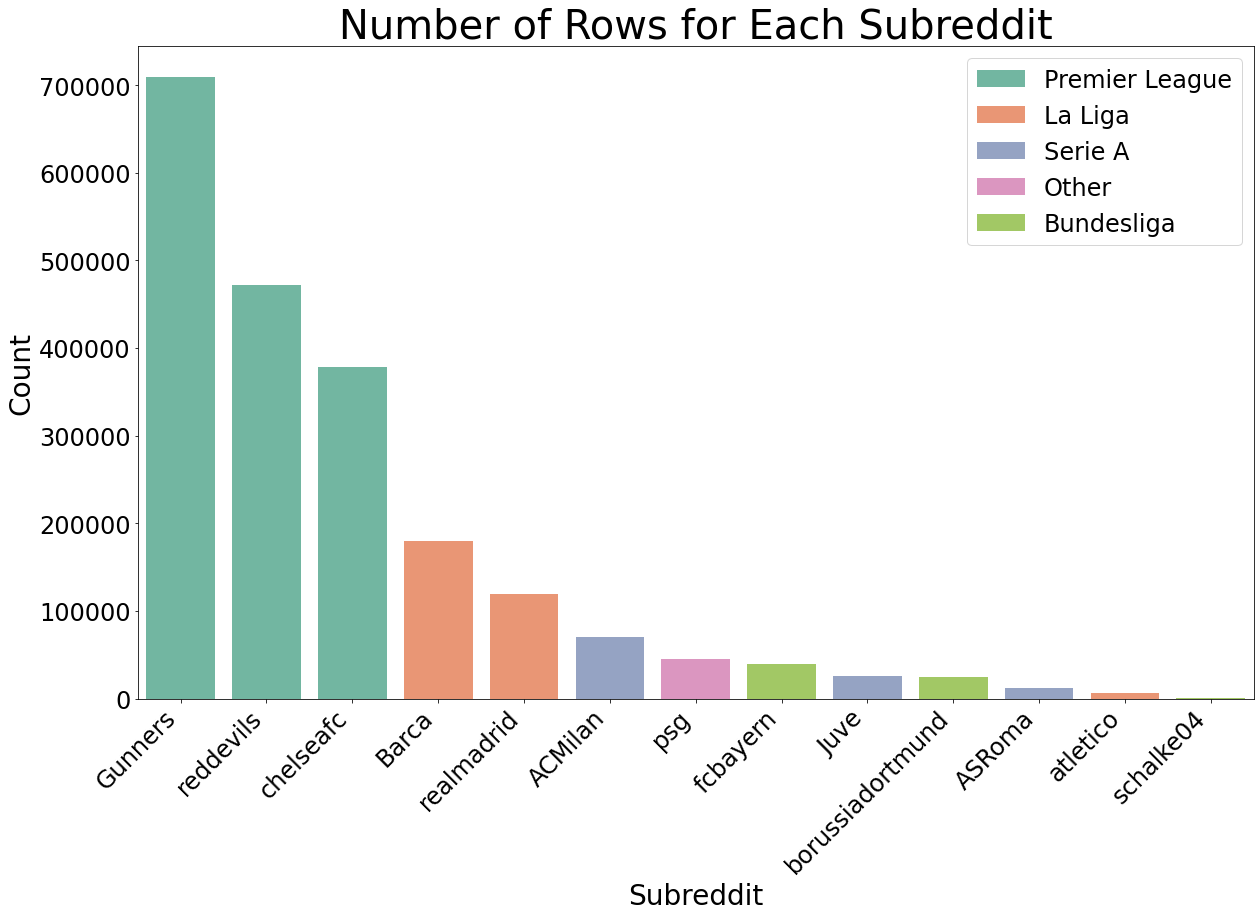

In [35]:
# plot bar plot for the number of comments for clubs
plt.figure(figsize=(20, 12))
sns.barplot(x='subreddit', y='count', hue='league', data=count_club, dodge=False, palette='Set2')
plt.title('Number of Rows for Each Subreddit', fontsize=40)
plt.xlabel('Subreddit', fontsize=28)
plt.ylabel('Count', fontsize=28)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis='both', labelsize=24)
plt.legend(fontsize=24, loc='upper right')
plt.show()

The barplot provides comment counts for popular European soccer clubs (three clubs for Premier League, La Liga, Serie A, and Bundesliga). The Premier League dominates, reflecting active discussions among English club enthusiasts. La Liga's "Barca" enjoys a robust presence, while Serie A's "ACMilan" showcases dedicated online discussions. Comparing with Premier League and La Liga, Serie A and Bundesliga are not popular on reddit but major clubs such as Milan and FC Bayern still stand out of the other clubs.